In [5]:
import h5py
import glob
import numpy as np
from util import plot
from util.atlas import Atlas
import matplotlib.pyplot as plt
from constants import SUBS

In [6]:
%cd ..

/scratch/gpfs/zzada/narrative-gradients


In [7]:
atlas = Atlas.schaefer(parcels=1000, networks=17, kong=True)

In [11]:
narratives = ['black', 'forgot']

modelname = 'whisper-tiny_3-layer'
modelname = 'whisper-medium_18-layer'
features = ['confounds', 'acoustic', 'encoder', 'decoder']

# model performance

In [12]:
def get_scores(modelname: str, foldername:str='encoding'):
    files = glob.glob(f'results/{foldername}/sub-*/{modelname}/*h5')

    black_scores = []
    forgot_scores = []
    for filename in files:
        with h5py.File(filename, 'r') as f:
            black_scores.append(f['black_scores'][...])
            forgot_scores.append(f['forgot_scores'][...])
    black_scores = np.stack(black_scores)
    forgot_scores = np.stack(forgot_scores)
    
    return black_scores, forgot_scores

In [13]:
sub_black_scores, sub_forgot_scores = get_scores(modelname)
avg_black_scores = sub_black_scores.mean(0)
avg_forgot_scores = sub_forgot_scores.mean(0)
sub_black_scores.shape, avg_black_scores.shape

((46, 4, 1000), (4, 1000))

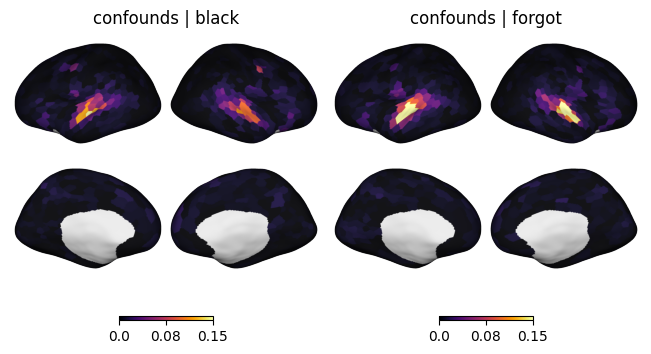

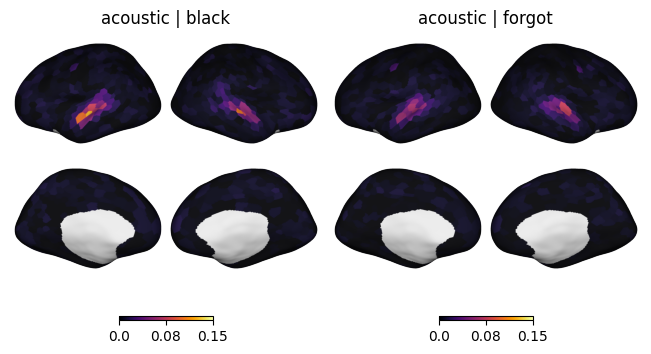

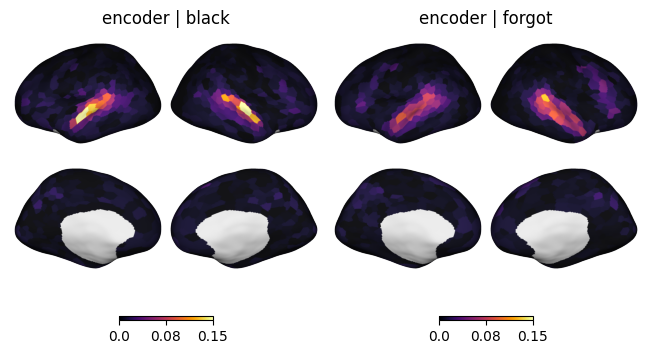

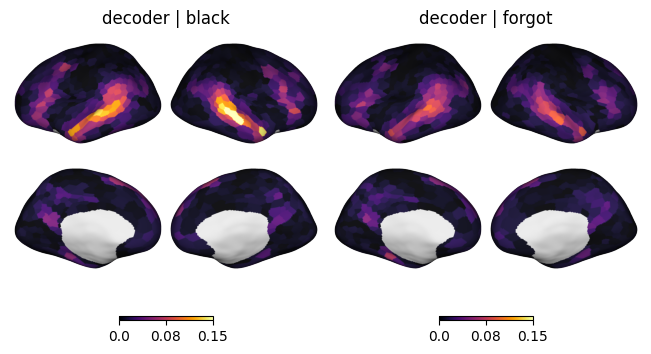

In [15]:
vmax = 0.15
# vmax = None

cmap = 'YlOrRd_r'
cmap = 'inferno'

for i, feature in enumerate(features):

    fig, axes = plt.subplots(1, 2, layout='constrained')

    values = avg_black_scores[i]
    plot.surface_plot(atlas.parc_to_vox(values), cmap=cmap, vmin=0, vmax=vmax, title=f'{feature} | black', fig=fig, ax=axes[0])

    values = avg_forgot_scores[i]
    plot.surface_plot(atlas.parc_to_vox(values), cmap=cmap, vmin=0, vmax=vmax, title=f'{feature} | forgot', fig=fig, ax=axes[1])

    fig.show()

## shifted model

In [74]:
black_scores, forgot_scores = get_scores('gemma-2b', foldername='encoding_shifted')

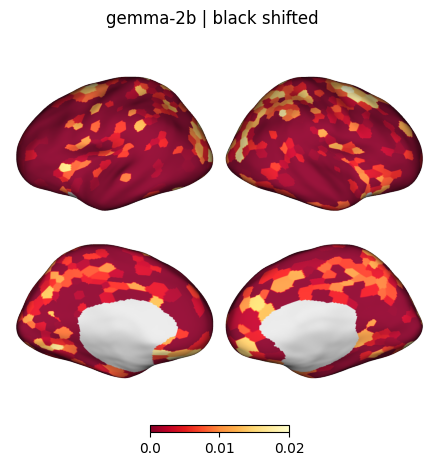

In [76]:
values = black_scores.mean(0)

fig = plot.surface_plot(atlas.parc_to_vox(values), cmap='YlOrRd_r', vmin=0, vmax=None, title=f'{modelname} | black shifted')
fig.show()

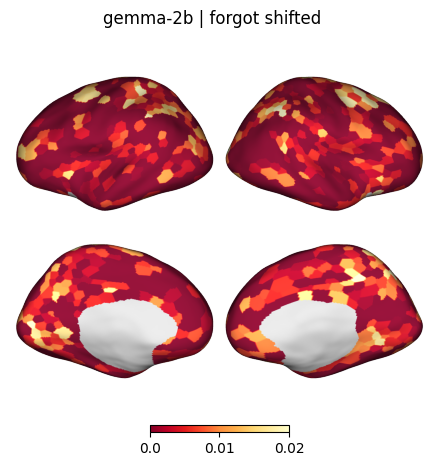

In [77]:
values = forgot_scores.mean(0)

fig = plot.surface_plot(atlas.parc_to_vox(values), cmap='YlOrRd_r', vmin=0, vmax=None, title=f'{modelname} | forgot shifted')
fig.show()

# model weights

In [44]:
foldername = 'encoding'
modelname = models[-1]
print(foldername, modelname)

files = glob.glob(f'results/{foldername}/sub-*/{modelname}/*h5')

black_preds = []
black_scores = []
black_weights = []
forgot_scores = []
forgot_weights = []

for filename in files:
    with h5py.File(filename, 'r') as f:
        black_scores.append(f['black_scores'][-1])
        black_weights.append(f['black_weights'][...])
        black_preds.append(f['black_preds'][-1])

        # forgot_scores.append(f['forgot_scores'][-1])
        # forgot_weights.append(f['forgot_weights'][...])

black_preds = np.stack(black_preds)
black_scores = np.stack(black_scores)
black_weights = np.stack(black_weights)
# forgot_scores = np.stack(forgot_scores)
# forgot_weights = np.stack(forgot_weights)

black_preds.shape, black_weights.shape

encoding gemma2-9b_22-layer


((46, 534, 1000), (46, 3584, 1000))

## average time-series and weights first

In [45]:
fc_preds = np.corrcoef(black_preds.mean(0).T, black_preds.mean(0).T)
n2 = len(fc_preds) // 2
fc_preds = fc_preds[n2:, :n2]
fc_preds.shape

(1000, 1000)

In [46]:
fc_weights = np.corrcoef(black_weights.mean(0).T, black_weights.mean(0).T)
n2 = len(fc_weights) // 2
fc_weights = fc_weights[n2:, :n2]
fc_weights.shape

(1000, 1000)

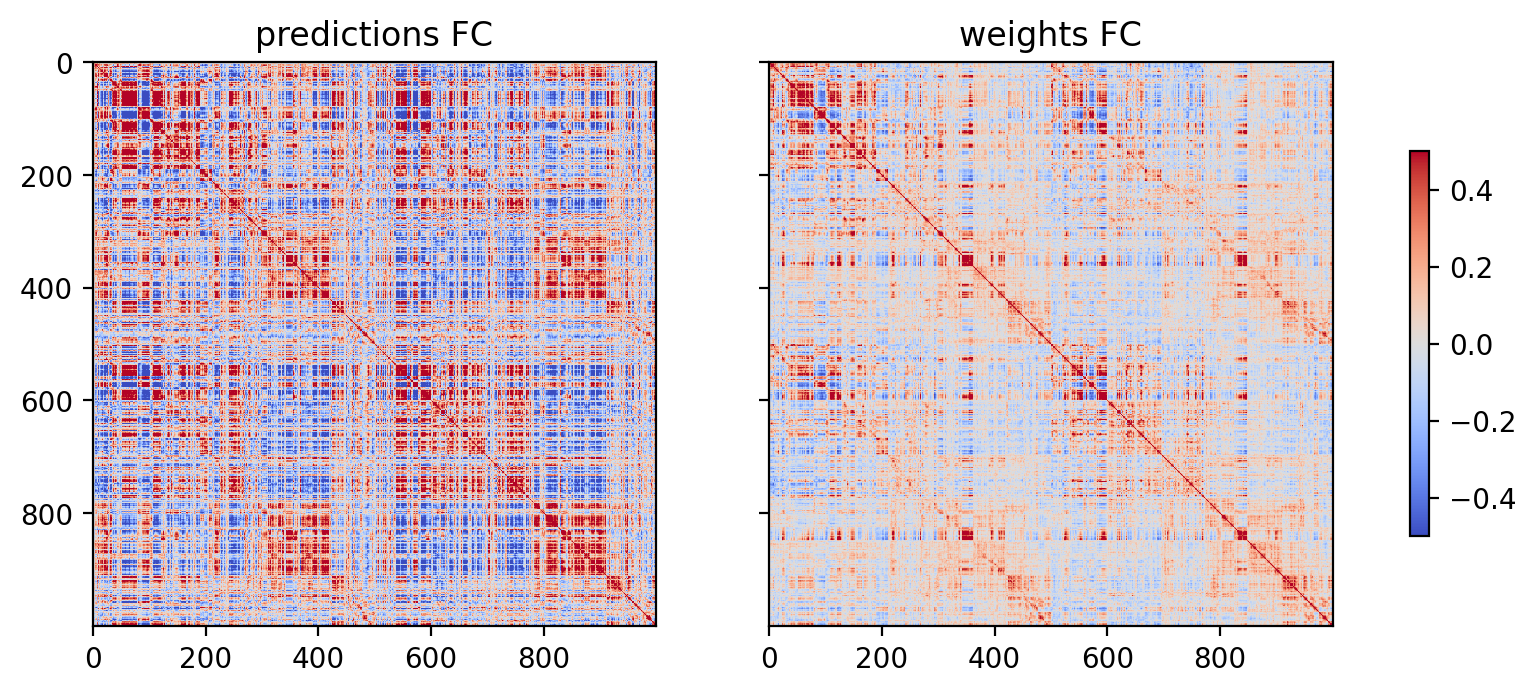

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, dpi=200)

vmin = -.5
vmax = .5

im = axes[0].imshow(fc_preds,   cmap='coolwarm', vmin=vmin, vmax=vmax)
im = axes[1].imshow(fc_weights, cmap='coolwarm', vmin=vmin, vmax=vmax)

axes[0].set_title("predictions FC")
axes[1].set_title("weights FC")

fig.colorbar(im, ax=axes, shrink=0.5)

fig.show()

## compute FC per subject first

In [48]:
fc_preds = np.stack([np.corrcoef(black_preds[i].T, black_preds[i].T)[1000:, :1000] for i in range(len(black_preds))])
fc_preds.shape

(46, 1000, 1000)

In [49]:
fc_weights = np.stack([np.corrcoef(black_weights[i].T, black_weights[i].T)[1000:, :1000] for i in range(len(black_weights))])
fc_weights.shape

(46, 1000, 1000)

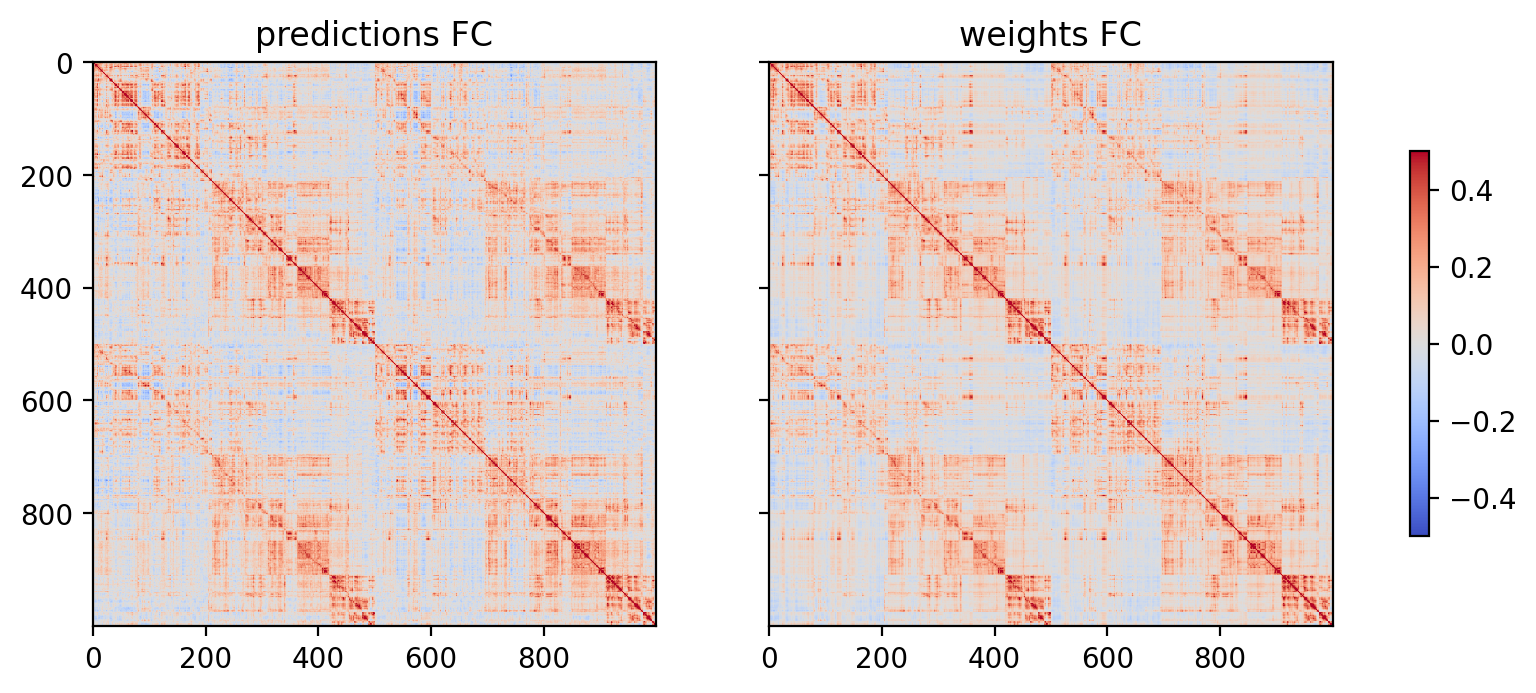

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True, dpi=200)

vmin = -.5
vmax = .5

im = axes[0].imshow(fc_preds.mean(0),   cmap='coolwarm', vmin=vmin, vmax=vmax)
im = axes[1].imshow(fc_weights.mean(0), cmap='coolwarm', vmin=vmin, vmax=vmax)

axes[0].set_title("predictions FC")
axes[1].set_title("weights FC")

fig.colorbar(im, ax=axes, shrink=0.5)

fig.show()

# joint model

In [60]:
foldername = 'joint_encoding'
modelname = 'NASL'
print(foldername, modelname)

files = glob.glob(f'results/{foldername}/sub-*/{modelname}/*h5')

black_scores = []
forgot_scores = []

for filename in files:
    with h5py.File(filename, 'r') as f:
        black_scores.append(f['black_scores'][...])
        forgot_scores.append(f['forgot_scores'][...])

black_scores = np.stack(black_scores)
forgot_scores = np.stack(forgot_scores)

black_scores.shape

joint_encoding NASL


(46, 4, 1000)

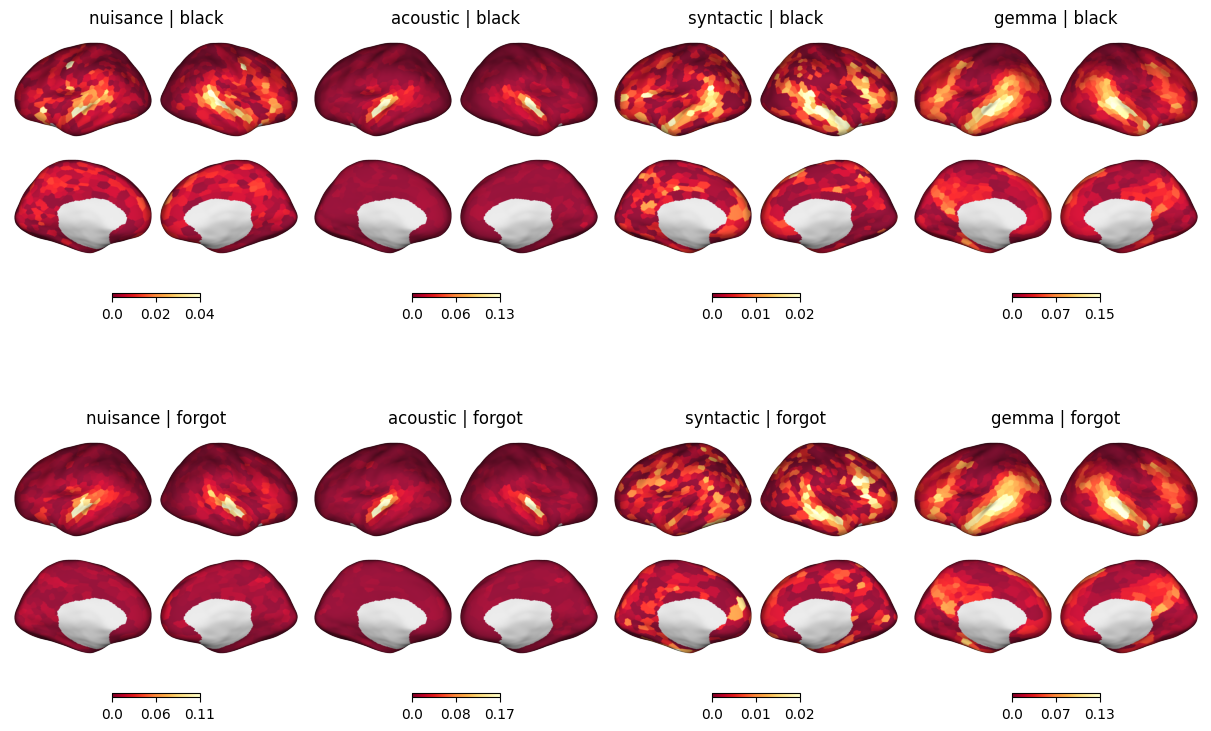

In [62]:
spaces = ['nuisance', 'acoustic', 'syntactic', 'gemma']

fig, axes = plt.subplots(2, len(spaces), layout='constrained', figsize=(12, 8))

for i, space in enumerate(spaces):
    values = black_scores[:, i, :].mean(0)
    plot.surface_plot(atlas.parc_to_vox(values), cmap='YlOrRd_r', vmin=0, title=f'{space} | black', fig=fig, ax=axes[0, i])

    values = forgot_scores[:, i, :].mean(0)
    plot.surface_plot(atlas.parc_to_vox(values), cmap='YlOrRd_r', vmin=0, title=f'{space} | forgot', fig=fig, ax=axes[1, i])

fig.show()

# quality check zeros

* h5disp = H5T_IEEE_F32LE (single)
* parcel 7 subject 17 near zeros for nuisance for joint model

## actual data

In [111]:
for modelname in models + ['NASL']:
    foldername = 'joint_encoding' if modelname == 'NASL' else 'encoding'
    files = sorted(glob.glob(f'results/{foldername}/sub-*/{modelname}/*h5'))
    assert len(files) > 0

    for filename in files:
        with h5py.File(filename, 'r') as f:
            for narrative in narratives:
                data = f[f'{narrative}_actual'][...]
                zeros0 = (data == 0).all(0)
                zeros = np.nonzero(zeros0)[0]
                if len(zeros):
                    print(filename.split('/')[-1], narrative, len(zeros), zeros)

## predecitions

NASL sub-301.h5 black 0 16 [  3 214 230 325 334 455 472 474 533 668 695 715 747 826 868 893]

In [112]:
for modelname in models + ['NASL']:
    foldername = 'joint_encoding' if modelname == 'NASL' else 'encoding'
    files = sorted(glob.glob(f'results/{foldername}/sub-*/{modelname}/*h5'))
    assert len(files) > 0

    for filename in files:
        with h5py.File(filename, 'r') as f:
            for narrative in narratives:
                data = f[f'{narrative}_preds'][...]
                zeros0 = (data == 0).all(1)
                for i in range(len(zeros0)):
                    zeros = np.nonzero(zeros0[i])[0]
                    if len(zeros):
                        print(modelname, filename.split('/')[-1], narrative, i, len(zeros), zeros)

NASL sub-301.h5 black 0 16 [  3 214 230 325 334 455 472 474 533 668 695 715 747 826 868 893]


## FC check


1. for each S, compute FC matrix from time series
2. z-transform FC matrix
3. average across Ss
4. undo z-transform

actual and predicted for each band separately

In [113]:
from scipy.spatial.distance import pdist, squareform

### actual

In [128]:
for modelname in models + ['NASL']:
    foldername = 'joint_encoding' if modelname == 'NASL' else 'encoding'
    files = sorted(glob.glob(f'results/{foldername}/sub-*/{modelname}/*h5'))
    assert len(files) > 0

    for filename in files:
        with h5py.File(filename, 'r') as f:
            for narrative in narratives:
                data = f[f'{narrative}_actual'][...]
                corr = 1 - pdist(data.T, metric='correlation')
                nans = np.isnan(corr).sum()
                if nans > 0:
                    print(modelname, filename.split('/')[-1], narrative, i, len(nans))

### preds

In [ ]:
# subject 301 is index 31 in python
# subject 17 in matlab is sub-286

In [127]:
for modelname in models + ['NASL']:
    foldername = 'joint_encoding' if modelname == 'NASL' else 'encoding'
    files = sorted(glob.glob(f'results/{foldername}/sub-*/{modelname}/*h5'))
    assert len(files) > 0

    for filename in files:
        with h5py.File(filename, 'r') as f:
            for narrative in narratives:
                data = f[f'{narrative}_preds'][...]
                for i in range(len(data)):
                    feature_data = data[i]
                    corr = 1 - pdist(feature_data.T, metric='correlation')
                    nans = np.isnan(corr).sum()
                    if nans > 0:
                        print(modelname, filename.split('/')[-1], narrative, i, nans)

NASL sub-301.h5 black 0 15864


In [130]:
narrative = 'black'
modelname = 'NASL'
foldername = 'joint_encoding'

files = sorted(glob.glob(f'results/{foldername}/sub-*/{modelname}/*h5'))
assert len(files) > 0

fcs = []
for filename in files:
    with h5py.File(filename, 'r') as f:
        data = f[f'{narrative}_preds'][0, ...]
        corr = 1 - pdist(data.T, metric='correlation')
        nans = np.isnan(corr).sum()
        if nans > 0:
            print(filename, nans)
        fcs.append(corr)

fc = np.stack(fcs).mean(0)
print(len(fcs), fc.shape, np.isnan(fc).sum())

results/joint_encoding/sub-301/NASL/sub-301.h5 15864
46 (499500,) 15864
